In [4]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from pprint import pprint
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg
from knowledge_tracing.trainer import Trainer

In [5]:
projectdir = Path('/code')
assert projectdir.exists()

In [6]:
experiment_name = '20_0218_edm2020_assistments09'
expsoutdir = projectdir / 'output' / experiment_name

cp_rp_paths = []
for expdir in sorted(expsoutdir.iterdir()):
    # Checkpoints
    cpdir = expdir / 'checkpoints'
    lastcpdir = sorted(cpdir.iterdir())[-1]
    bestcp_path = sorted(lastcpdir.iterdir())[-1]
    print(bestcp_path)
    # Report
    rpdir = expdir / 'report'
    lastrpdir = sorted(rpdir.iterdir())[-1]
    rp_path = next(lastrpdir.glob('*.json'))
    print(rp_path)
    cp_rp_paths.append((bestcp_path, rp_path))
    
# Asteria
configdics = []
for checkpoint_path, report_path in cp_rp_paths:
    with open(report_path, 'r') as f:
        report = json.load(f)
        config_dic = report['config']
        config_dic['load_model'] = str(checkpoint_path)
        configdics.append(config_dic)
        
def get_simu_res(config_dic):
    config = Config(config_dic, projectdir)
    config.batch_size = 1
    trainer = Trainer(config)
    
    trainer.evaluate_model()


    seq_size = config.sequence_size
    simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size+1)]

    simu_res = dict()
    for v in range(config.n_skills):
        xs = []
        preds = []
        for s in simu:
            res = trainer.model.loss_batch(
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.BoolTensor([True]*seq_size).unsqueeze(0),)
            preds.append(res['pred_prob'][-1].item())
            xs.append(sum(s))
        simu_res[v] = (xs, preds)
    return simu_res


simures_list = []
for config_dic in configdics:
    simu_res = get_simu_res(config_dic)
    simures_list.append(simu_res)
    

base_res = None
descres_list = []
for simu_res in simures_list:
    if base_res is None:
        base_res = {k:v for k, v in sorted(simu_res.items(), key=lambda it: it[1][1][0] - it[1][1][-1])}
    else:
        desc_res = {k:simu_res[k] for k in base_res.keys()}
        descres_list.append(desc_res)

INFO : 80 : 18:29 : ksdkt/assistments09 	| PyTorch: 1.3.0
INFO : 80 : 18:29 : ksdkt/assistments09 	| Using Device: cuda


/code/output/20_0218_edm2020_assistments09/assistments09/checkpoints/20200220-0009/ksdkt_auc0.8734_e1000.model
/code/output/20_0218_edm2020_assistments09/assistments09/report/20200220-0009/ksdkt.json
/code/output/20_0218_edm2020_assistments09/assistments09_straighten/checkpoints/20200219-2041/ksdkt_auc0.8750_e1000.model
/code/output/20_0218_edm2020_assistments09/assistments09_straighten/report/20200219-2041/ksdkt.json
/code/output/20_0218_edm2020_assistments09/assistments09_straighten_pre100/checkpoints/20200219-2144/ksdkt_auc0.8757_e1000.model
/code/output/20_0218_edm2020_assistments09/assistments09_straighten_pre100/report/20200219-2144/ksdkt.json
/code/output/20_0218_edm2020_assistments09/assistments09_straighten_pre200/checkpoints/20200219-2254/ksdkt_auc0.8755_e1000.model
/code/output/20_0218_edm2020_assistments09/assistments09_straighten_pre200/report/20200219-2254/ksdkt.json


ValueError: name is wrong

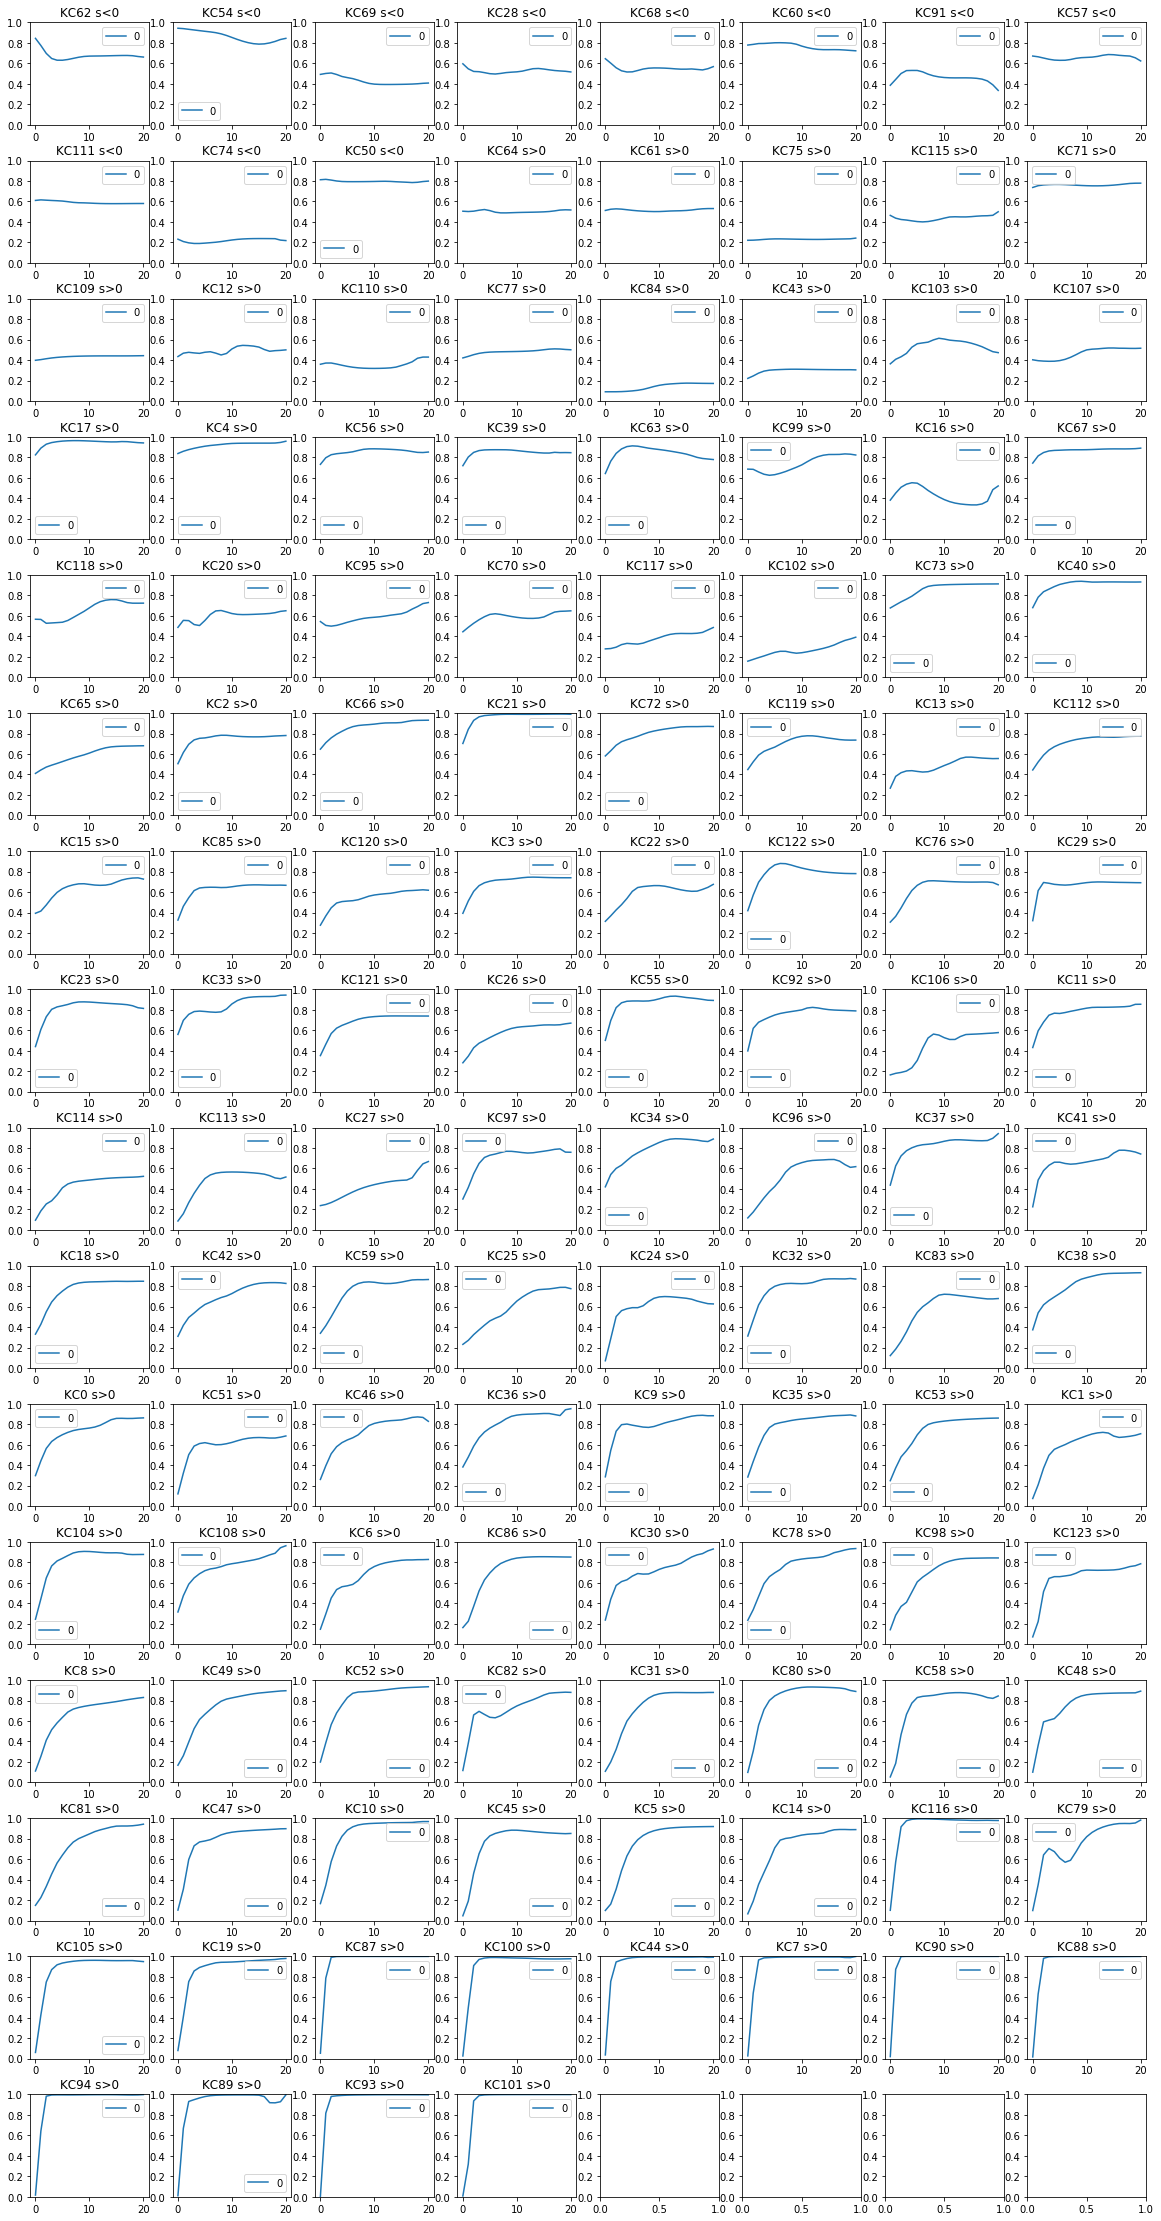

In [4]:
        
h, w = (124+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]<sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='0', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
ax.legend()
plt.show()

# Learning curve for `20_0218_edm2020_asmt0910`

In [74]:
config_name = '20_0218_edm2020_asmt0910'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['sequence_size'])
[r['config']['exp_name'] for r in report_dicts]

['pre_dummy_epoch_size100.auto',
 'pre_dummy_epoch_size150.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size50.auto',
 'pre_dummy_epoch_size5.auto',
 'pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size20.auto']

In [79]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
#     plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

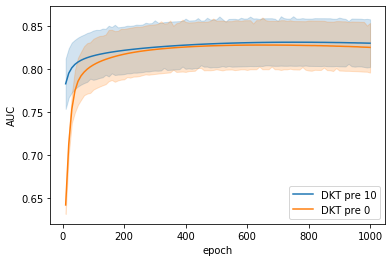

In [82]:
for r in report_dicts:
    pre = r['config']['pre_dummy_epoch_size']
    if pre not in {0, 10}:
        continue
    show_learning_curve(f'DKT pre {pre}', 0, r['indicator'])
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.show()

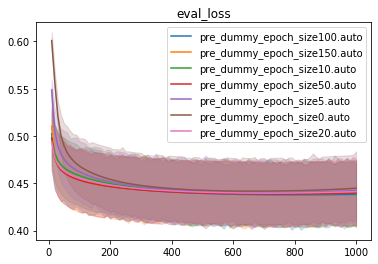

In [67]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Learning curve for `20_0220_edm2020_asmt15`

In [43]:
config_name = '20_0220_edm2020_asmt15'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['sequence_size'])
[r['config']['exp_name'] for r in report_dicts]

['sequence_size15padTrue.auto',
 'sequence_size15padFalse.auto',
 'sequence_size20padFalse.auto',
 'sequence_size20padTrue.auto',
 'sequence_size30padFalse.auto',
 'sequence_size30padTrue.auto',
 'sequence_size40padFalse.auto',
 'sequence_size40padTrue.auto',
 'sequence_size50padFalse.auto',
 'sequence_size50padTrue.auto',
 'sequence_size100padFalse.auto',
 'sequence_size100padTrue.auto']

In [44]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

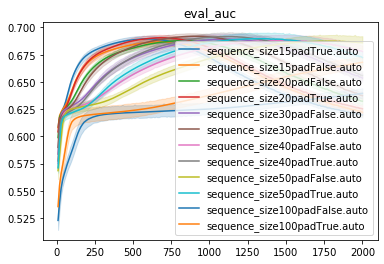

In [45]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

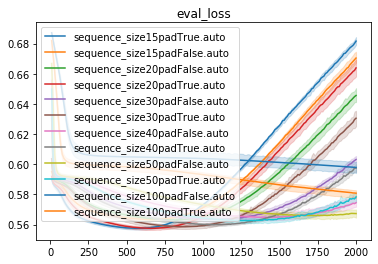

In [46]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0220_edm2020_asmt15`

In [47]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [48]:
for r in report_dicts:
    summarize_test_res(r)

sequence_size15padTrue.auto:	Best epoch at  600.0±14.1 	AUC: 69.0746±0.1098

sequence_size15padFalse.auto:	Best epoch at  694.0±8.9  	AUC: 68.7875±0.1249

sequence_size20padFalse.auto:	Best epoch at  836.0±31.3 	AUC: 68.8453±0.1469

sequence_size20padTrue.auto:	Best epoch at  686.0±33.6 	AUC: 69.1648±0.1259

sequence_size30padFalse.auto:	Best epoch at 1114.0±32.9 	AUC: 68.7813±0.1722

sequence_size30padTrue.auto:	Best epoch at  908.0±40.2 	AUC: 69.0504±0.1534

sequence_size40padFalse.auto:	Best epoch at 1482.0±76.0 	AUC: 68.3842±0.1075

sequence_size40padTrue.auto:	Best epoch at 1112.0±35.6 	AUC: 68.8973±0.0900

sequence_size50padFalse.auto:	Best epoch at 1776.0±68.0 	AUC: 68.5738±0.2209

sequence_size50padTrue.auto:	Best epoch at 1340.0±100.2	AUC: 68.8355±0.1611

sequence_size100padFalse.auto:	Best epoch at 2000.0±0.0  	AUC: 64.0471±0.3785

sequence_size100padTrue.auto:	Best epoch at 2000.0±0.0  	AUC: 66.3083±0.2184



# Learning curve for `20_0222_edm2020_asmt15`
Compare pre training effect

In [68]:
config_name = '20_0222_edm2020_asmt15'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['pre_dummy_epoch_size'])
[r['config']['exp_name'] for r in report_dicts]
# report_dicts = [c for c in report_dicts
#  if c['config']['pre_dummy_epoch_size'] in {0, 10, 200}]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size5.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size15.auto',
 'pre_dummy_epoch_size100.auto',
 'pre_dummy_epoch_size150.auto',
 'pre_dummy_epoch_size200.auto']

In [69]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

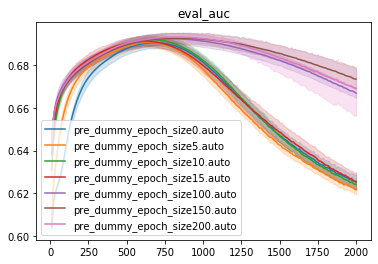

In [70]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

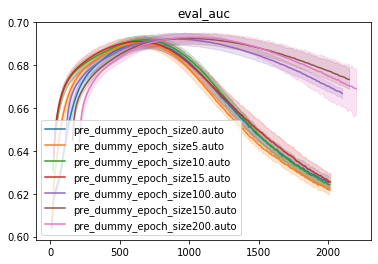

In [71]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], r['config']['pre_dummy_epoch_size'], r['indicator'])
plt.show()

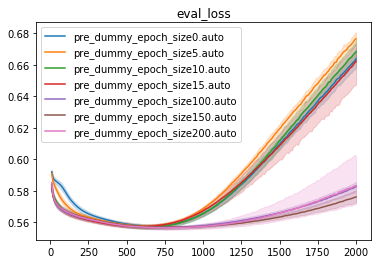

In [72]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0222_edm2020_asmt15`

In [53]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [54]:
for r in report_dicts:
    summarize_test_res(r)

pre_dummy_epoch_size15.auto:	Best epoch at  622.0±37.7 	AUC: 69.0644±0.0873

pre_dummy_epoch_size200.auto:	Best epoch at  830.0±89.2 	AUC: 69.3361±0.0983

pre_dummy_epoch_size100.auto:	Best epoch at  810.0±66.7 	AUC: 69.2795±0.0433

pre_dummy_epoch_size150.auto:	Best epoch at  850.0±64.4 	AUC: 69.2486±0.1468

pre_dummy_epoch_size10.auto:	Best epoch at  666.0±15.2 	AUC: 69.2182±0.1571

pre_dummy_epoch_size5.auto:	Best epoch at  652.0±23.9 	AUC: 69.1300±0.1551

pre_dummy_epoch_size0.auto:	Best epoch at  686.0±33.6 	AUC: 69.1648±0.1259



# Learning curve for `20_0301_edm2020_assist09`
Compare pre training effect

In [83]:
config_name = '20_0301_edm2020_assist09'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['pre_dummy_epoch_size'])
[r['config']['exp_name'] for r in report_dicts]
# report_dicts = [c for c in report_dicts
#  if c['config']['pre_dummy_epoch_size'] in {0, 10, 200}]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size5.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size20.auto',
 'pre_dummy_epoch_size50.auto',
 'pre_dummy_epoch_size100.auto',
 'pre_dummy_epoch_size150.auto',
 'pre_dummy_epoch_size200.auto']

In [84]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

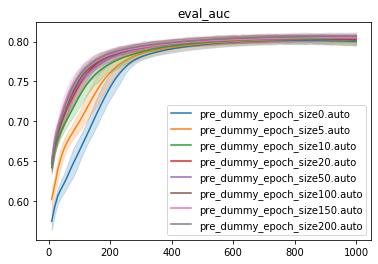

In [85]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

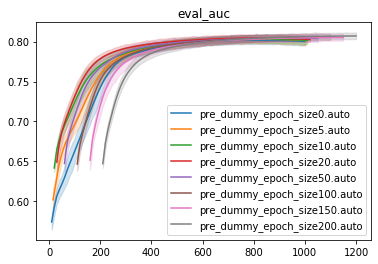

In [86]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], r['config']['pre_dummy_epoch_size'], r['indicator'])
plt.show()

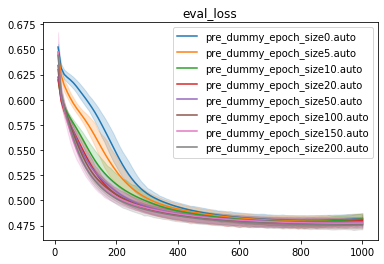

In [87]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0301_edm2020_assist09`

In [88]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [89]:
for r in report_dicts:
    summarize_test_res(r)

pre_dummy_epoch_size0.auto:	Best epoch at  818.0±95.5 	AUC: 80.0926±0.1322

pre_dummy_epoch_size5.auto:	Best epoch at  854.0±50.3 	AUC: 80.1581±0.1411

pre_dummy_epoch_size10.auto:	Best epoch at  806.0±58.6 	AUC: 80.2363±0.1182

pre_dummy_epoch_size20.auto:	Best epoch at  812.0±94.7 	AUC: 80.1628±0.1191

pre_dummy_epoch_size50.auto:	Best epoch at  892.0±71.9 	AUC: 80.3734±0.1494

pre_dummy_epoch_size100.auto:	Best epoch at  966.0±34.4 	AUC: 80.3333±0.1217

pre_dummy_epoch_size150.auto:	Best epoch at  960.0±52.4 	AUC: 80.3877±0.1809

pre_dummy_epoch_size200.auto:	Best epoch at  990.0±12.2 	AUC: 80.4489±0.0623



# Learning curve for `20_0301_edm2020_assist15`
Compare pre training effect

In [90]:
config_name = '20_0301_edm2020_assist15'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['pre_dummy_epoch_size'])
[r['config']['exp_name'] for r in report_dicts]
# report_dicts = [c for c in report_dicts
#  if c['config']['pre_dummy_epoch_size'] in {0, 10, 200}]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size5.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size15.auto',
 'pre_dummy_epoch_size100.auto',
 'pre_dummy_epoch_size150.auto',
 'pre_dummy_epoch_size200.auto']

In [91]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

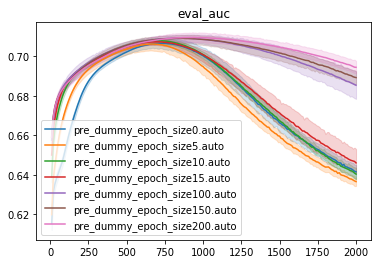

In [92]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

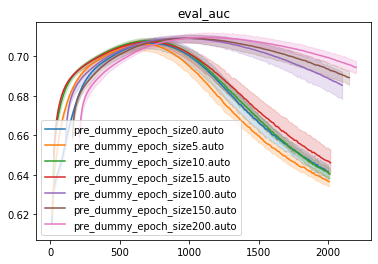

In [93]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], r['config']['pre_dummy_epoch_size'], r['indicator'])
plt.show()

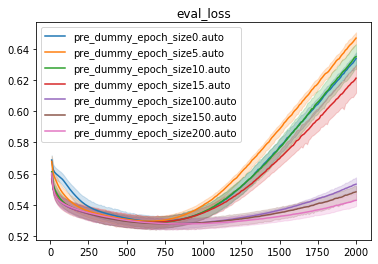

In [94]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0301_edm2020_assist15`

# Learning curve for `20_0303_edm2020_synthetic`
Compare pre training effect

In [97]:
config_name = '20_0303_edm2020_synthetic'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['pre_dummy_epoch_size'])
[r['config']['exp_name'] for r in report_dicts]
# report_dicts = [c for c in report_dicts
#  if c['config']['pre_dummy_epoch_size'] in {0, 10, 200}]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size3.auto',
 'pre_dummy_epoch_size8.auto',
 'pre_dummy_epoch_size20.auto',
 'pre_dummy_epoch_size50.auto',
 'pre_dummy_epoch_size150.auto',
 'pre_dummy_epoch_size400.auto']

In [116]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

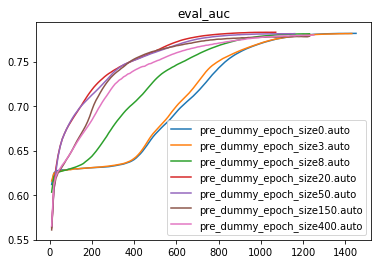

In [117]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

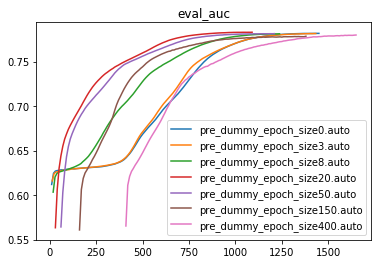

In [118]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], r['config']['pre_dummy_epoch_size'], r['indicator'])
plt.show()

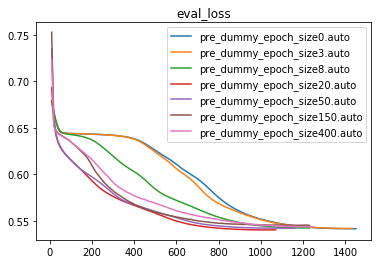

In [119]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0303_edm2020_synthetic`

# Learning curve for `20_0303_edm2020_statics`
Compare pre training effect

In [127]:
config_name = '20_0303_edm2020_statics'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['pre_dummy_epoch_size'])
[r['config']['exp_name'] for r in report_dicts]
# report_dicts = [c for c in report_dicts
#  if c['config']['pre_dummy_epoch_size'] in {0, 10, 200}]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size3.auto',
 'pre_dummy_epoch_size8.auto',
 'pre_dummy_epoch_size20.auto',
 'pre_dummy_epoch_size50.auto',
 'pre_dummy_epoch_size150.auto']

In [128]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

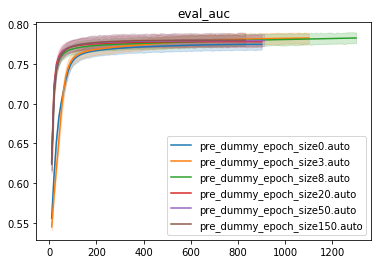

In [129]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

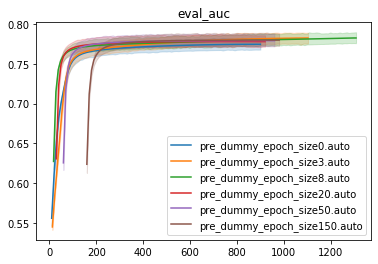

In [130]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], r['config']['pre_dummy_epoch_size'], r['indicator'])
plt.show()

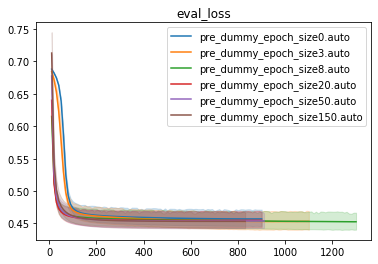

In [131]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0303_edm2020_statics`

In [132]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [133]:
for r in report_dicts:
    summarize_test_res(r)

pre_dummy_epoch_size0.auto:	Best epoch at  748.3±371.0	AUC: 78.7362±0.0760

pre_dummy_epoch_size3.auto:	Best epoch at 1035.0±573.4	AUC: 79.4221±0.2322

pre_dummy_epoch_size8.auto:	Best epoch at 1506.7±818.8	AUC: 79.7864±0.4362

pre_dummy_epoch_size20.auto:	Best epoch at  831.7±648.6	AUC: 79.1693±0.1772

pre_dummy_epoch_size50.auto:	Best epoch at  755.0±387.9	AUC: 79.2142±0.1184

pre_dummy_epoch_size150.auto:	Best epoch at  695.0±366.2	AUC: 79.2785±0.0815



# Learning curve for `20_0303_edm2020_assist09`
Compare pre training effect

In [14]:
config_name = '20_0303_edm2020_assist09'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['pre_dummy_epoch_size'])
[r['config']['exp_name'] for r in report_dicts]
# report_dicts = [c for c in report_dicts
#  if c['config']['pre_dummy_epoch_size'] in {0, 10, 200}]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size5.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size15.auto',
 'pre_dummy_epoch_size20.auto',
 'pre_dummy_epoch_size50.auto',
 'pre_dummy_epoch_size100.auto',
 'pre_dummy_epoch_size200.auto']

In [15]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

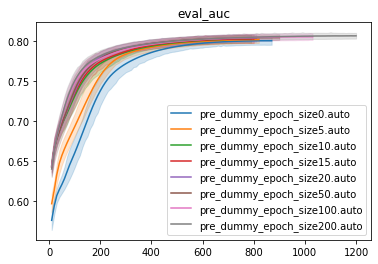

In [16]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

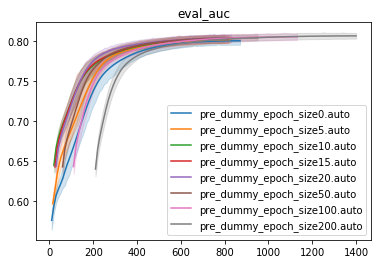

In [17]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], r['config']['pre_dummy_epoch_size'], r['indicator'])
plt.show()

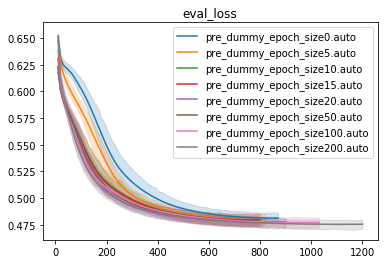

In [18]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0303_edm2020_assist09`

In [19]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [20]:
for r in report_dicts:
    summarize_test_res(r)

pre_dummy_epoch_size0.auto:	Best epoch at  721.7±359.5	AUC: 80.0535±0.1475

pre_dummy_epoch_size5.auto:	Best epoch at  685.0±338.4	AUC: 80.1052±0.1116

pre_dummy_epoch_size10.auto:	Best epoch at  658.3±328.8	AUC: 80.2604±0.0864

pre_dummy_epoch_size15.auto:	Best epoch at  666.7±334.5	AUC: 80.2179±0.2218

pre_dummy_epoch_size20.auto:	Best epoch at  678.3±334.5	AUC: 80.3069±0.1394

pre_dummy_epoch_size50.auto:	Best epoch at  750.0±375.6	AUC: 80.3590±0.1973

pre_dummy_epoch_size100.auto:	Best epoch at  858.3±424.6	AUC: 80.4585±0.1571

pre_dummy_epoch_size200.auto:	Best epoch at 1018.3±513.6	AUC: 80.5744±0.0919



# Learning curve for `20_0308_edm2020_assist09`
Compare pre training effect

In [7]:
config_name = '20_0308_edm2020_assist09'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['pre_dummy_epoch_size'])
[r['config']['exp_name'] for r in report_dicts]
# report_dicts = [c for c in report_dicts
#  if c['config']['pre_dummy_epoch_size'] in {0, 10, 200}]

['pre_dummy_epoch_size0',
 'pre_dummy_epoch_size8',
 'pre_dummy_epoch_size8_transfer_learning']

In [8]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

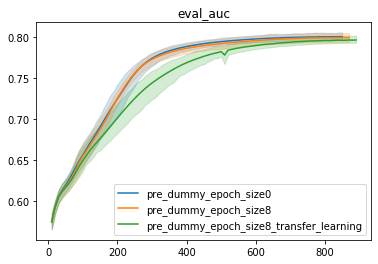

In [9]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

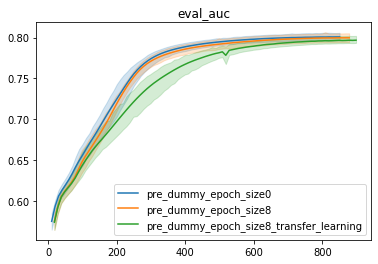

In [10]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], r['config']['pre_dummy_epoch_size'], r['indicator'])
plt.show()

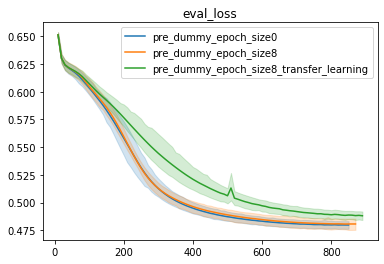

In [11]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0308_edm2020_assist09`

In [12]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [13]:
for r in report_dicts:
    summarize_test_res(r)

pre_dummy_epoch_size0:	Best epoch at  705.0±350.3	AUC: 80.1296±0.1783

pre_dummy_epoch_size8:	Best epoch at  723.3±361.6	AUC: 79.9781±0.2198

pre_dummy_epoch_size8_transfer_learning:	Best epoch at  745.0±366.2	AUC: 79.6754±0.2119

